<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/Patten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from google.colab import drive
import matplotlib.pyplot as plt
from keras.losses import LogCosh
from keras.optimizers import Adam
import warnings 

warnings.filterwarnings('ignore')

drive.mount('/content/gdrive')
train_data = pd.read_csv("/content/gdrive/MyDrive/MSFT_train.csv")
train_data.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073 entries, 0 to 9072
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9073 non-null   object 
 1   Open       9073 non-null   float64
 2   High       9073 non-null   float64
 3   Low        9073 non-null   float64
 4   Close      9073 non-null   float64
 5   Adj Close  9073 non-null   float64
 6   Volume     9073 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.3+ KB


In [2]:
features = ["Open", "High", "Low", "Volume"]
target = "Close"

sequences = 15
train_data = train_data.drop(['Date'], axis= 1)

In [3]:
def create_sequences(data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data[i-sequences:i, :])
        y.append(data[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [4]:
sc = MinMaxScaler(feature_range=(0,1))

train_data_scaled = sc.fit_transform(train_data.iloc[:, 4:5]).astype('float32')
X_train, y_train = create_sequences(train_data_scaled, sequences)
X_train.shape, y_train.shape

((9058, 15, 1), (9058,))

In [5]:
model = Sequential()
model.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer='Adam', loss='mse')

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
284/284 [==============================] - 12s 5ms/step - loss: 7.7769e-04
Epoch 2/10
284/284 [==============================] - 1s 4ms/step - loss: 4.5977e-05
Epoch 3/10
284/284 [==============================] - 2s 6ms/step - loss: 4.6005e-05
Epoch 4/10
284/284 [==============================] - 2s 6ms/step - loss: 4.4360e-05
Epoch 5/10
284/284 [==============================] - 2s 6ms/step - loss: 4.3548e-05
Epoch 6/10
284/284 [==============================] - 2s 7ms/step - loss: 3.6417e-05
Epoch 7/10
284/284 [==============================] - 1s 4ms/step - loss: 3.5092e-05
Epoch 8/10
284/284 [==============================] - 1s 4ms/step - loss: 3.2166e-05
Epoch 9/10
284/284 [==============================] - 1s 4ms/step - loss: 3.3506e-05
Epoch 10/10
284/284 [==============================] - 1s 4ms/step - loss: 3.0591e-05


In [6]:
model.evaluate(X_train, y_train, batch_size= 32)

284/284 [==============================] - 1s 2ms/step - loss: 4.0720e-05


4.0720431570662186e-05

In [95]:
test_df = pd.read_csv("/content/gdrive/MyDrive/MSFT_pred.csv")

test_data = test_df.copy()
test_data = test_data.iloc[:, 4:5]
preds = list()
days = 15

for i in range(1, days+1):
  test_data_scaled = sc.fit_transform(test_data)
  X_test, y_test = create_sequences(test_data_scaled, sequences)
  test_predictions = model.predict(X_test)
  inverse = sc.inverse_transform(test_predictions)
  preds.append(inverse[:, 0])
  test_data.drop(0, inplace=True)
  test_data = test_data.append(pd.Series(inverse[:,0], index=test_data.columns), ignore_index=True)


1/1 [==============================] - 0s 26ms/step


In [96]:
model.evaluate(X_test, y_test, batch_size= 32)

1/1 [==============================] - 0s 33ms/step - loss: 1.3192e-08


1.3192394732186585e-08

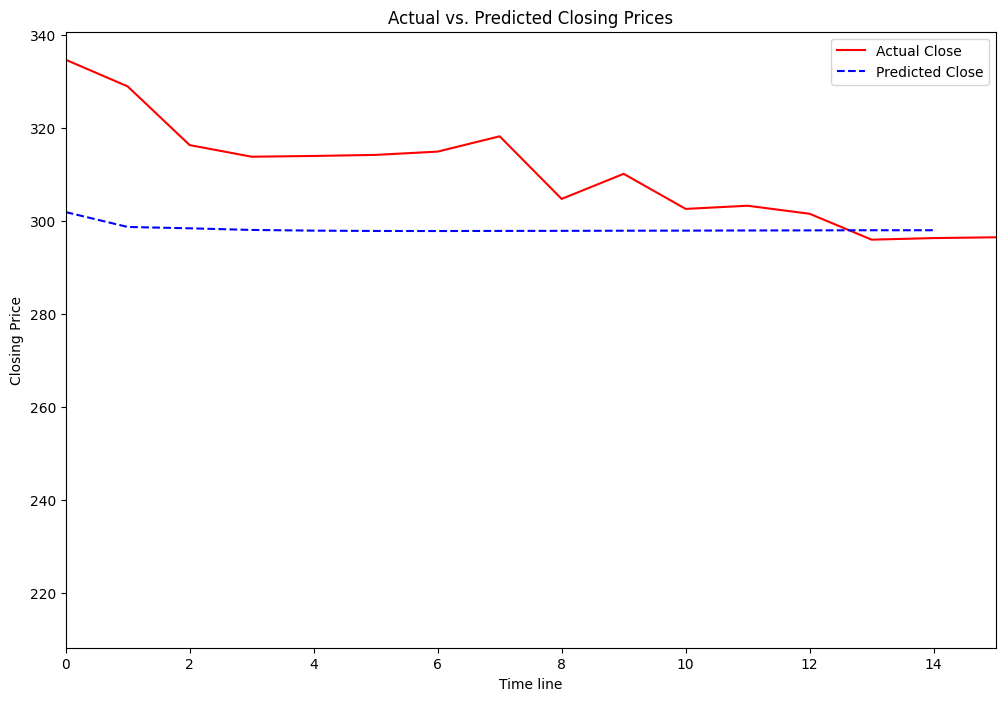

In [97]:
from numpy.ma import left_shift
import matplotlib.ticker as ticker
actual_data = pd.read_csv("/content/gdrive/MyDrive/MSFT_test.csv")

test_data_copy = actual_data.iloc[:len(actual_data)].copy()
Actual_Close = test_data_copy['Close'].drop(sequences)
result = preds

plt.figure(figsize=(12, 8))
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time line')
plt.ylabel('Closing Price')
plt.plot(Actual_Close, label='Actual Close', color='r')
plt.plot(result, label='Predicted Close', color='b', linestyle='--')
plt.xlim([0,days])
#ax= plt.gca()
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.legend()
plt.show()